# Hello PixelCNN using Tensorflow mixtyre distrobutions

In [4]:
# Prerequisites
import sys
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks
import tensorflow_probability as tfp

from utils import display

print("Python Version: ", sys.version)




Python Version:  3.12.7 (tags/v3.12.7:0b05ead, Oct  1 2024, 03:06:41) [MSC v.1941 64 bit (AMD64)]


### Get Data
Use FashionMNIST from TensorFlow datasets

In [14]:

(x_train, _), (_, _) = datasets.fashion_mnist.load_data()

### Preprocess Data

Scale down in size and image depth to make the training time reasonable

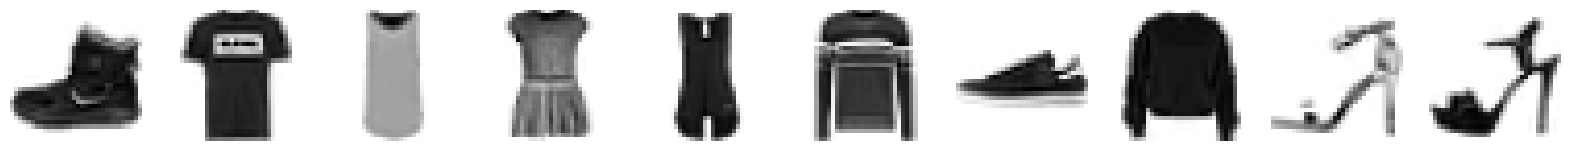

In [15]:
IMAGE_SIZE = 32

# Function to preprocess the images
def preprocess(imgs):
    imgs = np.expand_dims(imgs, -1)
    imgs = tf.image.resize(imgs, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
    return imgs


# Preprocess the training data
input_data = preprocess(x_train)

# Display some sample preprocessed images
display(input_data)

### Define PixelCNN

#### Define PixelCNN itself

In [16]:
N_COMPONENTS = 5

# Define a Pixel CNN network
dist = tfp.distributions.PixelCNN(
    image_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    num_resnet=1,
    num_hierarchies=2,
    num_filters=32,
    num_logistic_mix=N_COMPONENTS,
    dropout_p=0.3,
)

# Custom layer to compute and add negative log-likelihood loss
class LogProbLayer(layers.Layer):
    def call(self, inputs):
        log_prob = dist.log_prob(inputs)
        self.add_loss(-tf.reduce_mean(log_prob))  # Add loss internally
        return log_prob

# Define the model input
image_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

log_prob_output = LogProbLayer()(image_input)

# Define the model
pixelcnn = models.Model(inputs=image_input, outputs=log_prob_output)


### Train the PixelCNN

In [17]:
# Compile and train the model
pixelcnn.compile(
    optimizer=optimizers.Adam(0.001),
)

In [18]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def generate(self):
        return dist.sample(self.num_img).numpy()

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate()
        display(
            generated_images,
            n=self.num_img,
            save_to="./output/generated_md_img_%03d.png" % (epoch),
        )


img_generator_callback = ImageGenerator(num_img=2)

In [19]:
BATCH_SIZE = 128
EPOCHS = 10

# Fit the model
pixelcnn.fit(
    input_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=True,
    callbacks=[tensorboard_callback, img_generator_callback],
)

Epoch 1/10


d:\MyGithub\ML_Generative_AI_Experiments\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


 67/469 ━━━━━━━━━━━━━━━━━━━━ 2:17 342ms/step - loss: 4293.3779

KeyboardInterrupt: 

### Generate Images

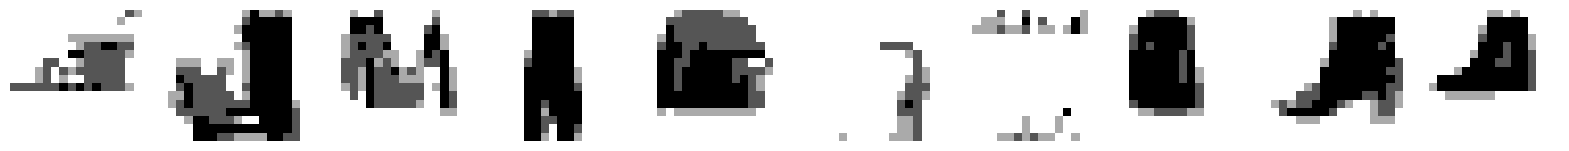

In [ ]:
generated_images = img_generator_callback.generate()
display(generated_images, n=img_generator_callback.num_img)